In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sy
import scipy.stats as ss
import scipy.signal
import pandas as pd
import PIL.Image
import os

import dynamics as dyn

**READ DATA (CMAPS)**

*Choose terminus (all protein/NR/CR) and MD run (run1/run2/run3/polyQ)*

*Change path for import and results to plot results from the last 2 us of the MD run*

In [7]:
run='run3'
path ='cmaps/all protein/{}'.format(run)

terminus='CR'
path_figures= 'results/figures'
savefig=1

N_termin_start=0
N_termin_end=224
C_termin_start=224

files = os.listdir(path)
files_csv = [f for f in files if f[-3:] == 'csv']
len_dataset=len(files_csv)
cmap= pd.read_csv('{}/{}'.format(path, files_csv[0]), header=None)

len_map=cmap.shape[0]
C_termin_end=cmap.shape[0]

dyn.set_layout()
len_dataset

1001

**PROCESS CMAPS**: 

*You can choose start and end residue for your analysis (0, C_termin_start, C_termin_end) and also the starting MD frame*

Fit parameters:
A = 0.05756843556461836, k = 1.9564976790064428


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


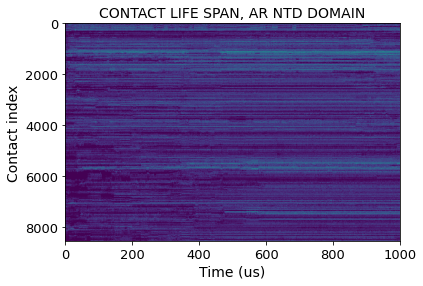

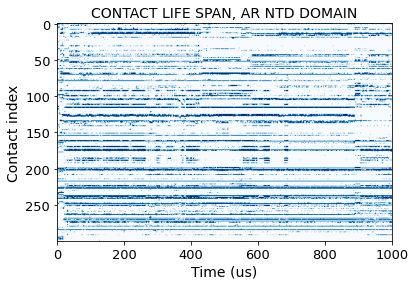

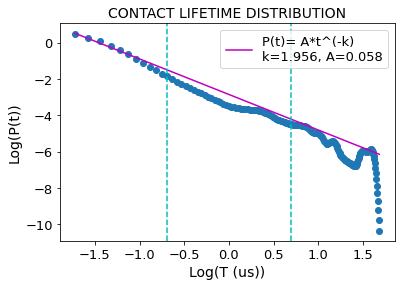

In [8]:
start=C_termin_start
end=C_termin_end
#end=C_termin_end
#end=len_map
start_frame=0
path_distributions= 'results/distributions/{}/{}'.format(terminus, run)
graph_cmap, dyn_cmap_flat=dyn.flatten_cmaps(start, end, start_frame, len_dataset,files_csv, path)

#Plot kymograph
a = dyn.plot_kymograph(graph_cmap)
#plot kymograph detail:
b = dyn.plot_kymograph(graph_cmap[0:300, :], cmap=1)

#Calculate maximum lifetime per contact
max_dist, max_lifetime_array, lifetime_matrix=dyn.find_max_lifetime_perres(dyn_cmap_flat, len_dataset)
#Make contact lifetime distribution
x,y,fit_dist,optim,max_array= dyn.lifetime_distribution(max_dist)

#Plot distribution with fit
c = dyn.log_plot(x,y,fit_dist,optim)

#Save figures and distributions in csv
if savefig: 
    plots = [a,b,c]
    name_figures = ['kymo', 'kimo_detail', 'lifetime']
    for plot in range(len(plots)):
        dyn.save_figures(plots[plot],path_figures, terminus, run, name_figures[plot])
        dist={'Time': x, 'Lifetime distribution': y,'Fit distributions':fit_dist, 'Terminus':terminus, 'Run':run}
        dist_df=pd.DataFrame(dist)
        dist_df.to_csv('{}/lifetime_distribution.csv'.format(path_distributions))
        

**MAKE LIFETIME FILTERS FOR CONTACT MAPS**

*Set thresholds in microseconds to divide short, middle and long lifetime*

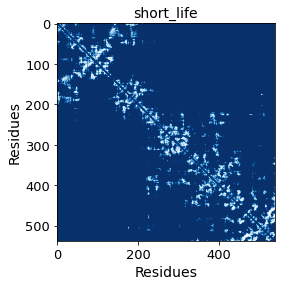

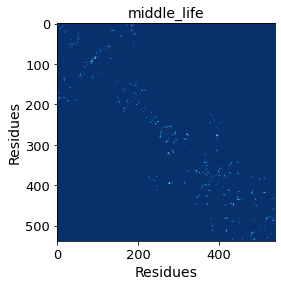

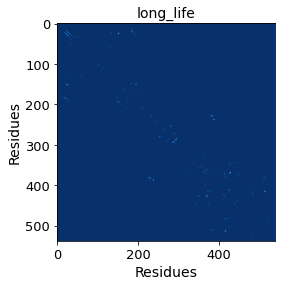

In [19]:
thresh1=0.5
thresh2=2.0
thresh=[thresh1,thresh2]
save_mask=1

lifetime= ['short_life', 'middle_life', 'long_life']
parameters=[N_termin_start,N_termin_end,C_termin_start,C_termin_end]
path_mask='results/masks/{}'.format(run)

for t in range(len(lifetime)):
    dyn.create_mask(max_lifetime_array, lifetime[t], thresh, parameters, path_mask, save_mask)
    

**CALCULATE C AND C* FACTOR**

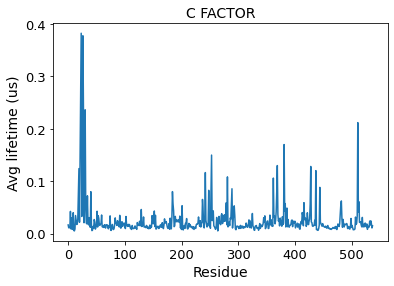

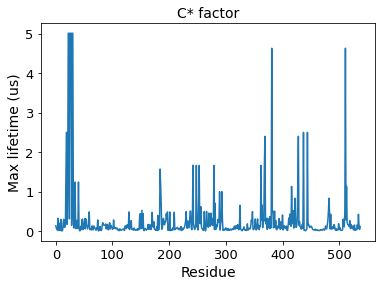

In [20]:
path_Cfactor= 'results/C_factor'

#Calculate all lifetimes for all existing contact in the MD run
all_lifetimes = dyn.compute_lifetime(max_lifetime_array,lifetime_matrix)
#Calculate average and max contact life per residue
avg_perres, max_perres = dyn.avg_lifetime_perres(all_lifetimes, max_lifetime_array, lifetime_matrix,
                                             C_termin_end)
#Plot C and C* factor
dyn.plot_Cfactors(avg_perres, max_perres, path_figures, run, savefig)
#Save C and C* factor to csv for further analysis
dyn.save_cfactor(avg_perres, max_perres, path_Cfactor, run)

**CALCULATE CONTACT RANGE**

*Choose among three modes for contact range calculation: 'average', 'max' and 'weighted'*

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

N terminus:
ShapiroResult(statistic=0.8836924433708191, pvalue=4.178312643793314e-12)
C terminus:
ShapiroResult(statistic=0.8897704482078552, pvalue=2.7303548012997184e-14)
Comparison distributions:
LeveneResult(statistic=10.876643757995936, pvalue=0.00103844364685063)
MannwhitneyuResult(statistic=34497.0, pvalue=0.3530013548186768)
Ttest_indResult(statistic=1.0977072368719887, pvalue=0.27282522190049346)


0

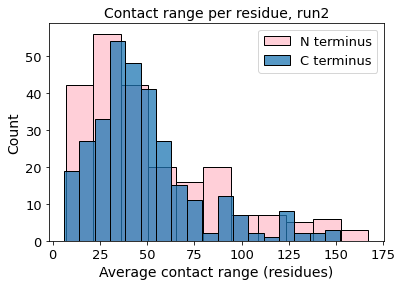

In [21]:
mode='weighted'
parameters=[N_termin_start,N_termin_end,C_termin_start,C_termin_end]

#Calculates the res-res range for spatial contacts. Three outputs: the average, max and weighted average contact range
ranges= dyn.avg_contact_range(all_lifetimes, max_lifetime_array, lifetime_matrix,C_termin_end)
#Plot the distribution of contact range for chosen mode
plot= dyn.plot_contact_range(ranges, parameters, path_figures, run, mode, savefig)
#Calculate the threshold for long range contacts
long_range_threshold= dyn.calculate_threshold(ranges, mode)
#Calculates statistics for N and C contact range distribution  
dyn.distribution_stats_mode(ranges, parameters, mode)  